In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Health Classification'

/content/drive/MyDrive/Health Classification


Merge all annotated data soruces

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
ep=pd.read_csv('/content/drive/MyDrive/Health Classification/Health classification EP/annotation_classified.csv')
com=pd.read_csv('/content/drive/MyDrive/Health Classification/Health classification Com/annotation_classified.csv')
council=pd.read_csv('/content/drive/MyDrive/Health Classification/Health classification Council/council_annotation_with_llm_scoring.csv')

In [ ]:
ep=ep[['current', 'bartu_annotation',
       'is_climate_LLM', 'llm_explanation']].rename(columns={'current': 'sentence'})
com=com[['sentence_text_en', 'bartu_annotation',
       'is_climate_LLM', 'llm_explanation']].rename(columns={'sentence_text_en': 'sentence'})
council=council[['sentence', 'bartu_annotation',
       'is_climate_LLM', 'llm_explanation']].rename(columns={'sentence': 'sentence'})

In [ ]:
merged_df = pd.concat([ep, com, council], ignore_index=True)

In [ ]:
# Convert '-' to NaN in 'bartu_annotation'
merged_df['bartu_annotation'] = merged_df['bartu_annotation'].replace('-', np.nan)

# Drop rows where either 'bartu_annotation' or 'is_climate_LLM' is NaN
merged_df.dropna(subset=['bartu_annotation', 'is_climate_LLM'], inplace=True)

# Convert columns to integer
merged_df['is_climate_LLM'] = merged_df['is_climate_LLM'].astype(int)
merged_df['bartu_annotation'] = merged_df['bartu_annotation'].astype(int)


# Display the data types of the columns to confirm
print(merged_df.dtypes)
display(merged_df.head())

sentence            object
bartu_annotation     int64
is_climate_LLM       int64
llm_explanation     object
dtype: object


,sentence,bartu_annotation,is_climate_LLM,llm_explanation
0,"But I am wondering, Mr Draghi, what you are wa...",0,1,**1**\n\nThis sentence is about health in the ...
1,We hope that it will soon be possible to compl...,1,1,**1**\n\nThis sentence is about health in the ...
2,The pandemic has had a dramatic impact on the ...,1,1,1\n\nThis sentence is about health in the EU p...
3,I would like an explanation as to why parliame...,1,1,**1**\n\nThis sentence is about health in the ...
4,(DE) I welcome the directive on patients’ righ...,1,1,1\n\nThis sentence is about health in the EU p...


In [ ]:
merged_df.to_csv('gold_all.csv', index=False)

In [ ]:
# Install Hugging Face libraries
!pip install -q transformers datasets evaluate

In [ ]:
# --------------------------
# 1. Imports
# --------------------------
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import evaluate

In [ ]:
# --------------------------
# 2. Load Your CSV (single file)
# --------------------------
# Columns: 'sentence' (text), 'bartu_annotation' (label)
gold_all = load_dataset("csv", data_files="gold_all.csv")["train"]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Count occurrences of each class
class_counts = gold_all.to_pandas()['bartu_annotation'].value_counts()

# Identify classes with only one member
single_member_classes = class_counts[class_counts == 1].index.tolist()

# Filter out examples belonging to single-member classes
gold_all_filtered = gold_all.filter(lambda example: example['bartu_annotation'] not in single_member_classes)


Filter:   0%|          | 0/2101 [00:00<?, ? examples/s]

In [ ]:
class_counts

,count
bartu_annotation,
0,1232
1,869


In [ ]:

# Convert the 'bartu_annotation' column to ClassLabel on the filtered dataset
gold_all_filtered = gold_all_filtered.class_encode_column("bartu_annotation")

# Perform the stratified train/validation/test split on the filtered dataset
train_valid_test = gold_all_filtered.train_test_split(test_size=0.3, stratify_by_column="bartu_annotation")
temp = train_valid_test['test'].train_test_split(test_size=0.5, stratify_by_column="bartu_annotation")

gold_data = DatasetDict({
    'train': train_valid_test['train'].rename_column("bartu_annotation", "labels"),
    'validation': temp['train'].rename_column("bartu_annotation", "labels"),
    'test': temp['test'].rename_column("bartu_annotation", "labels")
})

print("Original dataset size:", len(gold_all))
print("Filtered dataset size:", len(gold_all_filtered))
print("Train set size:", len(gold_data['train']))
print("Validation set size:", len(gold_data['validation']))
print("Test set size:", len(gold_data['test']))
gold_all=gold_all_filtered

Stringifying the column:   0%|          | 0/2101 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2101 [00:00<?, ? examples/s]

Original dataset size: 2101
Filtered dataset size: 2101
Train set size: 1470
Validation set size: 315
Test set size: 316


In [ ]:
# --------------------------
# 4. Tokenization
# --------------------------
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=256)

gold_data = gold_data.map(tokenize, batched=True)
gold_data = gold_data.remove_columns(["sentence"])  # drop text column

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/316 [00:00<?, ? examples/s]

In [ ]:
# --------------------------
# 5. Model + Metrics
# --------------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": metric.compute(predictions=preds, references=labels)["f1"]}

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 6. Training Arguments - Corrected
training_args = TrainingArguments(
    output_dir="./results_gold_only",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs_gold_only",
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=gold_data['train'],
    eval_dataset=gold_data['validation'],
    # removed processing_class=AutoTokenizer
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# --------------------------
# 7. Train + Evaluate
# --------------------------
trainer.train()
results = trainer.evaluate(gold_data['test'])
print("Gold-only Results on Test Set:", results)

Epoch,Training Loss,Validation Loss,F1
1,No log,0.484321,0.927007
2,No log,0.438287,0.943396
3,No log,0.446917,0.938931


Gold-only Results on Test Set: {'eval_loss': 0.4783186614513397, 'eval_f1': 0.9358490566037736, 'eval_runtime': 3.8772, 'eval_samples_per_second': 81.502, 'eval_steps_per_second': 5.158, 'epoch': 3.0}


In [ ]:
# Save the trained model
output_dir = "./saved_model"
trainer.save_model(output_dir)

print(f"Model saved to {output_dir}")

Dataset({
    features: ['Unnamed: 0', 'speech_id', 'preceding', 'following', 'speaker', 'party', 'date', 'agenda', 'speechnumber', 'procedure_ID', 'period', 'chair', 'MEP', 'commission', 'written', 'multispeaker', 'link', 'translationInSpeech', 'how_many_words_in_climate_mitigation_dictionary', 'labels', 'is_climate_LLM', 'llm_explanation', 'input_ids', 'attention_mask'],
    num_rows: 700
})
{'Unnamed: 0': 103, 'speech_id': 275717, 'preceding': 'There is no doubt about what is happening, today we have solid data and a strong consensus on the part of the scientific community around global climate change.', 'following': 'What we have done is not enough.', 'speaker': 'José Inácio Faria', 'party': 'ALDE', 'date': '2015-01-28', 'agenda': '14. Roadmap towards a new international climate agreement in Paris (debate) (debate)', 'speechnumber': 11, 'procedure_ID': None, 'period': 8, 'chair': False, 'MEP': True, 'commission': False, 'written': False, 'multispeaker': False, 'link': 'https://www.

In [ ]:
# Identify non-numeric values in 'bartu_annotation'
non_numeric_values = merged_df[pd.to_numeric(merged_df['bartu_annotation'], errors='coerce').isna()]['bartu_annotation'].unique()
print("Non-numeric values in 'bartu_annotation':", non_numeric_values)

Non-numeric values in 'bartu_annotation': [nan]


In [ ]:
print("Number of NaN values in 'is_climate_LLM':", merged_df['is_climate_LLM'].isna().sum())

Number of NaN values in 'is_climate_LLM': 9


In [ ]:
# Save the trained model
output_dir = "./saved_model"
trainer.save_model(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ./saved_model


Precision per class: [0.96153846 0.92537313]
Recall per class: [0.94594595 0.94656489]
F1-score per class: [0.95367847 0.93584906]

Overall Precision: 0.9465458733595896
Overall Recall: 0.9462025316455697
Overall F1-score: 0.946287164956538


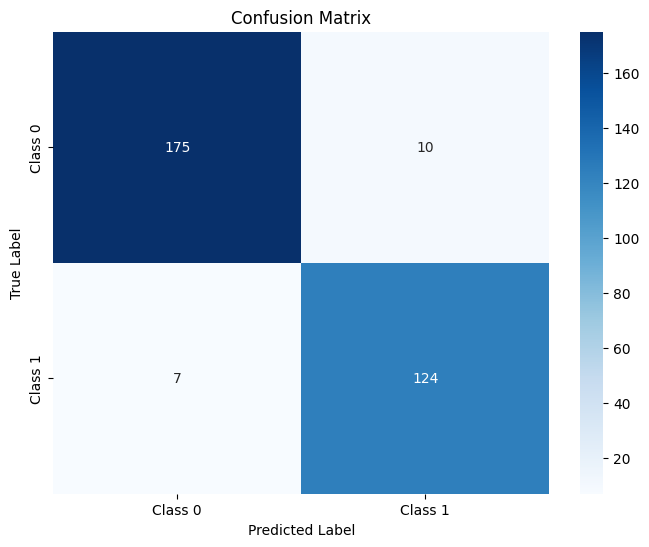

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
predictions = trainer.predict(gold_data['test'])
logits = predictions.predictions
labels = predictions.label_ids

# Calculate precision, recall, and f1-score per class
precision, recall, f1, _ = precision_recall_fscore_support(labels, np.argmax(logits, axis=-1), average=None)

# Calculate overall precision, recall, and f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(labels, np.argmax(logits, axis=-1), average='weighted')


print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)
print("\nOverall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)

# Generate confusion matrix
cm = confusion_matrix(labels, np.argmax(logits, axis=-1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()